### Studying Vulnerabilities in Package Dependency Networks
Code for analysing strong connectivity and building the condensation of package dependency networks. A condensation is a network where strongly connected componentes are contracted into single vertices, thus producing a directed acyclic graph (DAG).

Uses input files in adjacency list format produced by _write_adjlist_ method from NetworkX.

In [1]:
import networkx as nx
from statistics import mean 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def condensation_report(G):
    """
    Searchs for strongly connected components (SCCs) in the given directed 
    graph and builds its condensation. 
    Outputs some stats about SCCs count and intra-SCC properties.
    
    Parameters
    ----------
    G : NetworkX Graph
        Directed graph with cycles.
    Returns
    -------
    GC : Condensation of G
    scc_sizes : Sizes of SCCs in G
    scc_out : Out degrees of SCCs in G
    scc_in : In degrees of SCCs in G
    """
    if nx.is_directed_acyclic_graph(G):
        print("Network is acyclic")
        return
    print('Finding strongly connected components (SCCs)...')
    scc = nx.strongly_connected_components(G)
    scc = list(scc)
    print('Building condensation...')
    GC = nx.condensation(G,scc)
    print('Adding structural meta-data...')
    
    # Model includes weighted edges to represent 
    # ingoing/outgoing dependencies to/from SCC
    for e in GC.edges:
        GC.edges[e]['weight'] = 0
    for n in GC.nodes:
        GC.nodes[n]['intra_edges'] = 0
    
    for n in G:
        for e in G.in_edges(n):
            u, v = e
            map_u = GC.graph['mapping'][u]
            map_v = GC.graph['mapping'][v]
            if map_u==map_v:        
                # Number of edges inside SCC
                GC.nodes[map_u]['intra_edges']+=1     
            else:
                # Weight for edge to/from SCC
                GC.edges[(map_u, map_v)]['weight']+=1

    scc_sizes, scc_out, scc_in, scc_count = [], [], [], 0
    
    for n in GC.nodes:
        if len(GC.nodes[n]['members'])>1:
            scc_sizes.append(len(GC.nodes[n]['members']))
            scc_out.append(GC.out_degree[n])
            scc_in.append(GC.in_degree[n])
            scc_count += 1
    
    print("--------------------------------------------------------")
    print(f'Original graph has {len(G)} nodes and {len(scc)} SCCs')
    print(f'{len(G)-len(scc)}({round(100*(len(G)-len(scc))/len(G),4)}%)'+
          ' nodes of the original graph are in SCCs larger than one node')
    print()
    print(f'{scc_count} SCCs larger than one node:')
    print(f'   Size: MIN {min(scc_sizes)}, MAX {max(scc_sizes)}, AVG { round(mean(scc_sizes),2)}')
    plt.plot(sorted(scc_sizes, reverse=True))
    plt.show()
    print(f'   Out degree: MIN {min(scc_out)}, MAX {max(scc_out)}, AVG { round(mean(scc_out),2)}')
    plt.plot(sorted(scc_out, reverse=True))
    plt.show()
    print(f'   In degree: MIN {min(scc_in)}, MAX {max(scc_in)}, AVG { round(mean(scc_in),2)}')
    plt.plot(sorted(scc_in, reverse=True))
    plt.show()
    return GC, scc_sizes, scc_out, scc_in

#### Simple model example

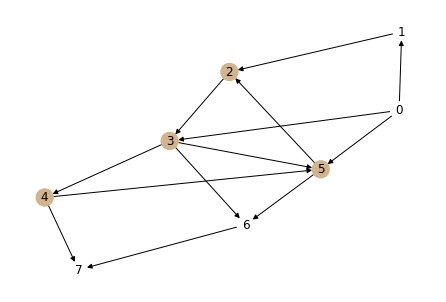

In [21]:
G=nx.DiGraph()

G.add_edges_from([[0,1],
                 [1,2],
                 [2,3],
                 [3,4],
                 [4,5],
                 [5,2],
                 [5,6],
                 [6,7],
                 [3,5],
                 [0,3],
                 [4,7],
                 [0,5],
                 [3,6]])
nx.draw(G,pos=nx.kamada_kawai_layout(G),with_labels=True,
        node_color=['white','white','tan','tan','tan','tan','white','white'])

Tan nodes form a SCC in the original digraph.

Finding strongly connected components (SCCs)...
Building condensation...
Adding structural meta-data...
--------------------------------------------------------
Original graph has 8 nodes and 5 SCCs
3(37.5%) nodes of the original graph are in SCCs larger than one node

1 SCCs larger than one node:
   Size: MIN 4, MAX 4, AVG 4


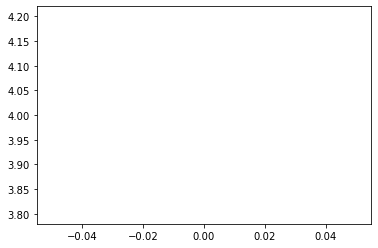

   Out degree: MIN 2, MAX 2, AVG 2


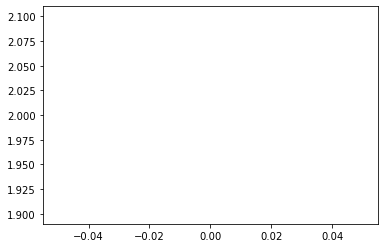

   In degree: MIN 2, MAX 2, AVG 2


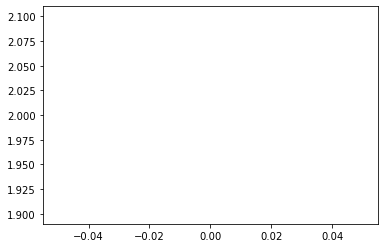

In [22]:
GC, scc_sizes, scc_out, scc_in = condensation_report(G)

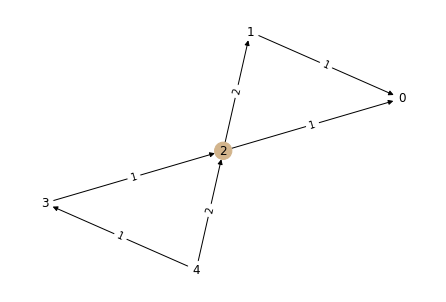

In [23]:
pos=nx.kamada_kawai_layout(GC,weight='None')
colors=['white' if len(GC.nodes[n]['members'])==1 else 'tan' for n in GC.nodes]
nx.draw(GC,pos,with_labels=True, node_color=colors)

labels = nx.get_edge_attributes(GC,'weight')
_=nx.draw_networkx_edge_labels(GC,pos,edge_labels=labels)

As _networkx.strongly_connected_components()_ uses [Tarjan's algorithm](https://en.wikipedia.org/wiki/Tarjan%27s_strongly_connected_components_algorithm), SCCs are returned in reverse topological order and hence the condensation graph GC has its nodes indexed in reversed topological order.

The condensation graph includes all the mapping information we will need, a dictionary of original names and node indexes as a graph attribute, _GC.graph\['mapping'\]_ and a set of members for each contracted SCC at node attribute level.

 Node '2' here is the contraction of '2','3','4' and '5' in original digraph.

In [24]:
GC.graph['mapping']

{7: 0, 6: 1, 2: 2, 3: 2, 4: 2, 5: 2, 1: 3, 0: 4}

In [10]:
GC.nodes[2]['members']

{2, 3, 4, 5}

Edge weights in the model represent the number of dependencies going to/from the members of SCC in the original digraph:

In [14]:
GC.edges[4,2]['weight']

2

And we also store the original number of dependencies into each SCC.

In [16]:
GC.nodes[2]['intra_edges']

5

#### PyPI model

In [25]:
G = nx.read_adjlist("pypi-dependencies-net-2020-01-12.bz2", create_using=nx.DiGraph())

Finding strongly connected components (SCCs)...
Building condensation...
Adding structural meta-data...
--------------------------------------------------------
Original graph has 50766 nodes and 50690 SCCs
76(0.1497%) nodes of the original graph are in SCCs larger than one node

51 SCCs larger than one node:
   Size: MIN 2, MAX 7, AVG 2.49


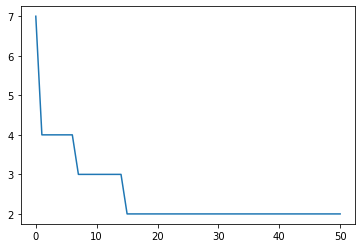

   Out degree: MIN 0, MAX 1057, AVG 36.24


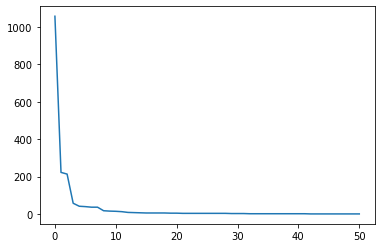

   In degree: MIN 0, MAX 34, AVG 11.37


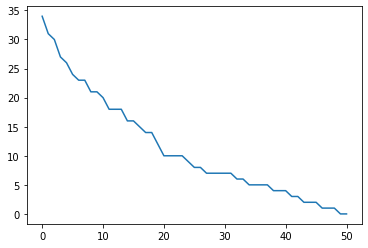

In [26]:
GC, scc_sizes, scc_out, scc_in = condensation_report(G)

In [108]:
# Saving the complete structure as a compressed pickle object
nx.write_gpickle(GC,'npm-dependencies-net-2020-01-12_dag-model_B.bz2')